In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import statsmodels.api as sm

from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter

from multipathogen_sero import (
    simulate_infections,
    simulate_infections_survivor,
    simulation_to_regression_df,
    simulation_to_survey_long,
    survey_long_to_wide
)
from multipathogen_sero.config import EXTERNAL_DATA_DIR

# Load the data

In [141]:
mordor_df = pd.read_csv(EXTERNAL_DATA_DIR / 'mordor-ab-analysis-public.csv')
mordor_df['testdate'] = pd.to_datetime(mordor_df['testdate'])
start_date = mordor_df['testdate'].min()
mordor_df['test_month'] = 12*(mordor_df['testdate'].dt.year - start_date.year) + mordor_df['testdate'].dt.month - start_date.month

pathogen_antigen_df = mordor_df[['pathogen', 'antigen','serocut','serocut_desc']].drop_duplicates()
pathogen_antigen_df['logserocut'] = np.log10(pathogen_antigen_df['serocut'])
child_visit_df = mordor_df[['clusterid_public', 'phase', 'arm', 'childid_public', 'agem',
       'agem_start', 'agem_start_under6', 'sex', 'testdate', 'test_month', 'wet_start',
       'wet_end', 'season', 'malaria_thicksmear', 'malaria_density',
       'malaria_gameto', 'dbsid', 'type', 'well']].drop_duplicates()

# Calculate implied_birth_month and agem_is_rounded
child_visit_df = child_visit_df.assign(
    implied_birth_month=lambda df: df['test_month'] - df['agem'],
    agem_is_rounded=lambda df: df['agem'] % 6 == 0
)

def compute_birth_month(group):
    if not group['agem_is_rounded'].all():
        val = group.loc[~group['agem_is_rounded'], 'implied_birth_month'].mean()
    else:
        val = group['implied_birth_month'].mean()
    val = min(min(group['test_month']), val) #ensure birth month is not later than test month
    return pd.Series({'averaged_birth_month': val})

birth_month_df = (
    child_visit_df
    .groupby('childid_public')
    .apply(compute_birth_month, include_groups=False)
    .reset_index()
)

# Merge averaged_birth_month back into child_visit_df and calculate agem_est
child_visit_df = (
    child_visit_df
    .merge(birth_month_df, on='childid_public', how='left')
    .assign(agem_est=lambda df: df['test_month'] - df['averaged_birth_month'])
)

mordor_df = (
    mordor_df
    .merge(child_visit_df[['childid_public', 'phase', 'agem_est']], on=['childid_public', 'phase'], how='left')
)

sero_df = mordor_df[['childid_public', 'test_month', 'agem_est', 'phase', 'pathogen', 'antigen',
       'antigenf', 'mfi', 'logmfi', 'seropos']]


In [143]:
seropositivity_long = sero_df[['childid_public', 'test_month', 'agem_est', 'phase', 'antigen', 'seropos']]
seropositivity_wide = seropositivity_long.pivot_table(
    index=['childid_public', 'test_month', 'agem_est', 'phase'],
    columns='antigen',
    values='seropos',
    aggfunc='first'
).reset_index()

log_mfi_long = sero_df[['childid_public', 'test_month', 'agem_est', 'phase', 'antigen', 'logmfi']]
log_mfi_wide = log_mfi_long.pivot_table(
    index=['childid_public', 'test_month', 'agem_est', 'phase'],
    columns='antigen',
    values='logmfi',
    aggfunc='first'
).reset_index()

# column summaries

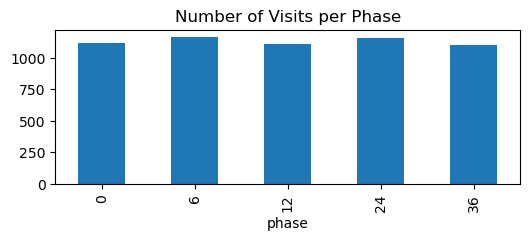

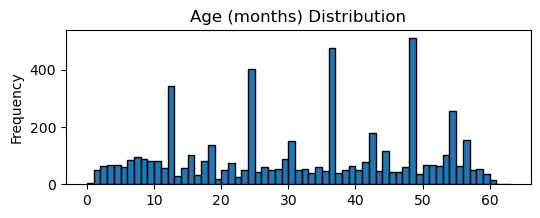

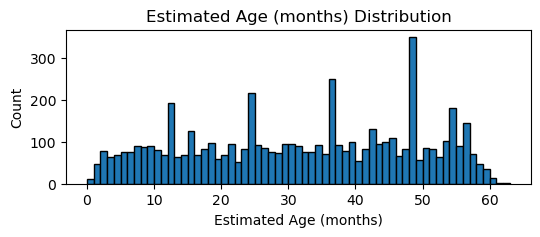

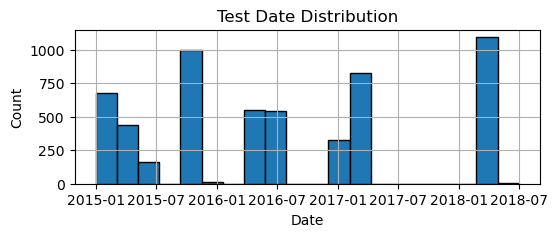

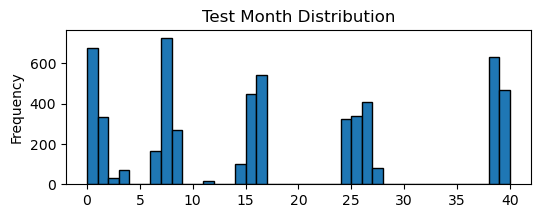

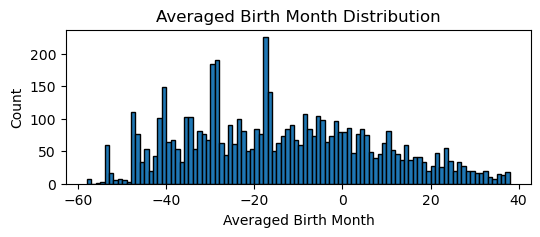

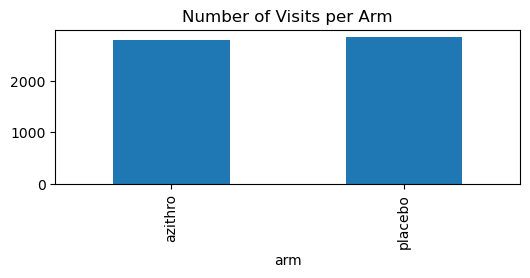

In [ ]:
#plot bar chart of phase, ordering by phase
plt.figure(figsize=(6, 2))
child_visit_df['phase'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Visits per Phase')
#plot histogram of age, binwidth = 2
plt.figure(figsize=(6, 2))
child_visit_df['agem'].plot(kind='hist', bins=np.arange(0, 64, 1), edgecolor='black')
plt.title('Age (months) Distribution')
#plot histogram of agem_est, binwidth = 1
plt.figure(figsize=(6, 2))
child_visit_df['agem_est'].plot(kind='hist', bins=np.arange(0, 64, 1), edgecolor='black')
plt.title('Estimated Age (months) Distribution')
plt.xlabel('Estimated Age (months)')
plt.ylabel('Count')
#plot histogram of test_month, binwidth = 1
plt.figure(figsize=(6, 2))
child_visit_df['test_month'].plot(kind='hist', bins=np.arange(0, child_visit_df['test_month'].max() + 1, 1), edgecolor='black')
plt.title('Test Month Distribution')
#plot histogram of averaged_birth_month, binwidth = 1
plt.figure(figsize=(6, 2))
child_visit_df['averaged_birth_month'].plot(kind='hist', bins=np.arange(child_visit_df['averaged_birth_month'].min(), child_visit_df['averaged_birth_month'].max() + 1, 1), edgecolor='black')
plt.title('Averaged Birth Month Distribution')
plt.xlabel('Averaged Birth Month')
plt.ylabel('Count')
#plot bar chart of arm, ordering by arm
plt.figure(figsize=(6, 2))
child_visit_df['arm'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Visits per Arm')
plt.show()




### seropositivity

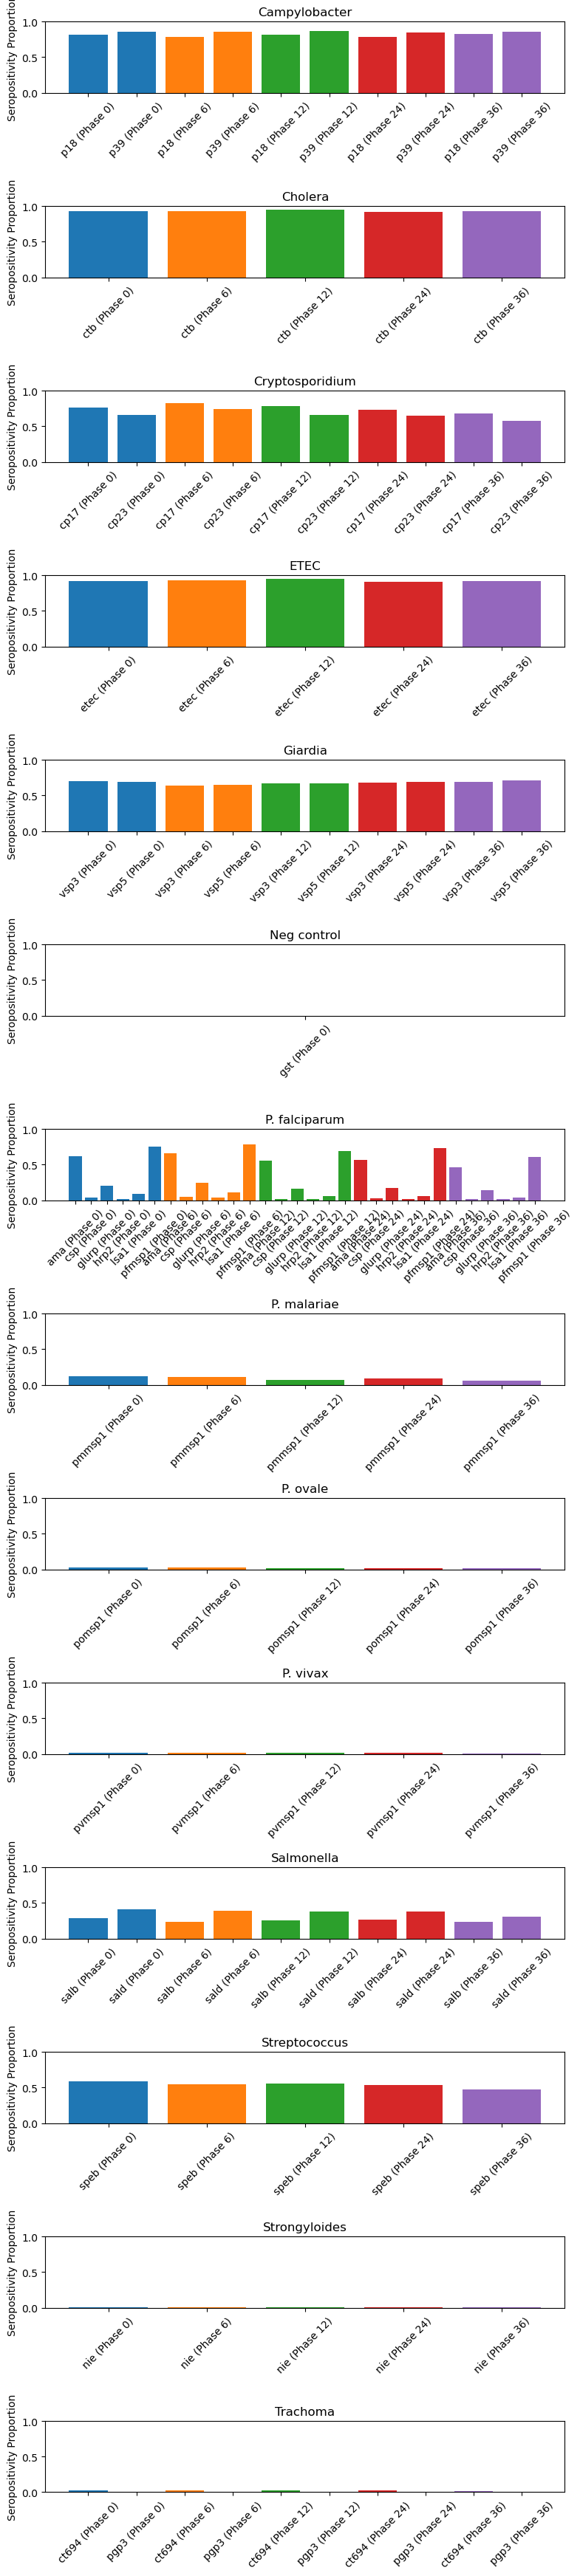

pathogen antigen  serocut    serocut_desc  logserocut
0   Cryptosporidium    cp17    290.0        external    2.462398
1   Cryptosporidium    cp23    945.0        external    2.975432
2           Giardia    vsp3    154.0        external    2.187521
3           Giardia    vsp5    147.0        external    2.167317
4          Trachoma    pgp3   1613.0        external    3.207634
5          Trachoma   ct694    457.0        external    2.659916
6     Streptococcus    speb    884.0  presumed unexp    2.946452
7     Campylobacter     p39    338.0  presumed unexp    2.528917
8     Campylobacter     p18    843.0  presumed unexp    2.925828
9        Salmonella    sald     10.0  presumed unexp    1.000000
10       Salmonella    salb     11.0  presumed unexp    1.041393
11             ETEC    etec    866.0  presumed unexp    2.937518
12          Cholera     ctb    438.0  presumed unexp    2.641474
13    Strongyloides     nie   3523.0        external    3.546913
14    P. falciparum    hrp2   5336.0        external    3.727216
15    P. falciparum     csp    926.0        external    2.966611
16    P. falciparum   glurp    123.0        external    2.089905
17    P. falciparum  pfmsp1    221.0        external    2.344392
18         P. ovale  pomsp1    462.0        external    2.664642
19      Neg control     gst      NaN             NaN         NaN
20         P. vivax  pvmsp1    787.0        external    2.895975
21      P. malariae  pmmsp1    431.0        external    2.634477
22    P. falciparum    lsa1    447.0        external    2.650308
23    P. falciparum     ama    646.0        external    2.810233

In [65]:
# Calculate seropositivity proportions for each antigen and phase
sero_summary = (
    sero_df.groupby(['pathogen', 'antigen', 'phase'])['seropos']
    .mean()
    .reset_index()
)

# Get unique pathogens
pathogens = sero_summary['pathogen'].unique()

# Determine the grid layout for the panels
n_rows = len(pathogens)
fig, axes = plt.subplots(n_rows, 1, figsize=(8, 2.5 * n_rows))  # Adjust height for better spacing

# If there's only one pathogen, axes won't be an array, so we handle it separately
if n_rows == 1:
    axes = [axes]

# Create individual bar charts for each pathogen
for i, pathogen in enumerate(pathogens):
    pathogen_data = sero_summary[sero_summary['pathogen'] == pathogen]
    
    # Create a bar chart for the current pathogen
    for phase in pathogen_data['phase'].unique():
        phase_data = pathogen_data[pathogen_data['phase'] == phase]
        axes[i].bar(
            phase_data['antigen'] + f" (Phase {phase})",
            phase_data['seropos'],
            label=f"Phase {phase}"
        )
    
    # Add labels and title
    axes[i].set_ylabel('Seropositivity Proportion')
    axes[i].set_title(f'{pathogen}')
    axes[i].tick_params(axis='x', rotation=45)
    
    # Set y-axis limits from 0 to 1
    axes[i].set_ylim(0, 1)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()
pathogen_antigen_df

### mfi distribution

Serocut for pmmsp1: 431.0 (external)


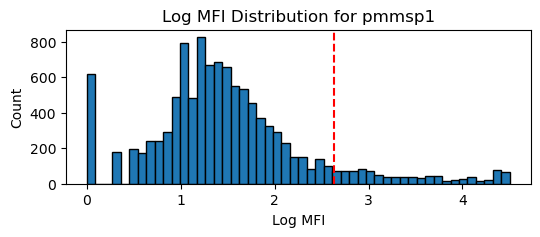

In [106]:
#### OPTIONS ####
antigen = 'pmmsp1'
#################
serocut_value = pathogen_antigen_df[pathogen_antigen_df['antigen'] == antigen]['serocut'].values[0]
logserocut_value = pathogen_antigen_df[pathogen_antigen_df['antigen'] == antigen]['logserocut'].values[0]
serocut_desc = pathogen_antigen_df[pathogen_antigen_df['antigen'] == antigen]['serocut_desc'].values[0]
print(f'Serocut for {antigen}: {serocut_value} ({serocut_desc})')

# plot histogram of logmfi for a specific antigen
plt.figure(figsize=(6, 2))
sero_df[sero_df['antigen'] == antigen]['logmfi'].plot(kind='hist', bins=50, edgecolor='black')
plt.title(f'Log MFI Distribution for {antigen}')
plt.xlabel('Log MFI')
plt.ylabel('Count')
#add dashed line at serocut
plt.axvline(logserocut_value, color='red', linestyle='--', label='Serocut')
plt.show()

C:\Users\alexy\AppData\Local\Temp\ipykernel_51184\1203526482.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_categories))  # Use a discrete colormap


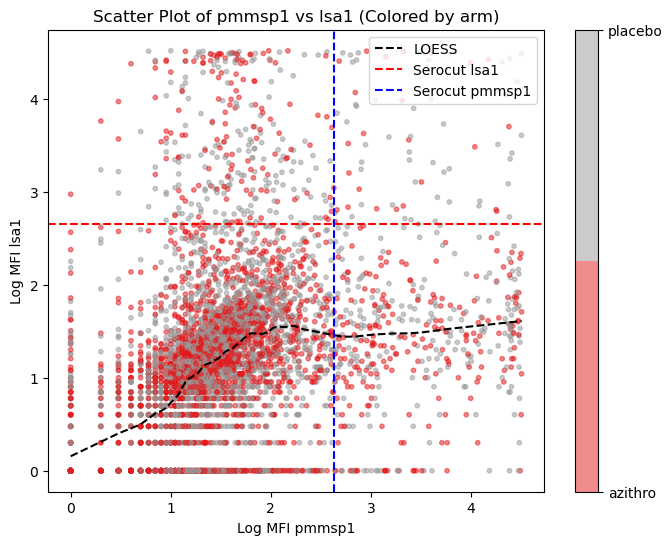

In [107]:
#### OPTIONS ####
# for Campylobacter, use p18 and p39
# for malaria (different species), try lsa1 and pmmsp1
antigen_1 = 'pmmsp1'
antigen_2 = 'lsa1'
colour_by = 'arm'  # Options: 'agem', 'phase', 'arm'
trendline = 'loess' # 'pc1', 'loess', 'ols' or None
#################


if colour_by in log_mfi_wide.columns:
    log_mfi_with_colour_by = log_mfi_wide
else:
    # Merge log_mfi_wide with child_visit_df to include the colour_by column
    log_mfi_with_colour_by = log_mfi_wide.merge(
        child_visit_df[['childid_public', 'test_month', colour_by]],
        on=['childid_public', 'test_month'],
        how='left'
    )

# Extract serocut values for the two antigens
logserocut_1 = pathogen_antigen_df[pathogen_antigen_df['antigen'] == antigen_1]['logserocut'].values[0]
logserocut_2 = pathogen_antigen_df[pathogen_antigen_df['antigen'] == antigen_2]['logserocut'].values[0]

# Check if the colour_by column is numeric or categorical
if (log_mfi_with_colour_by[colour_by].dtype == 'object' or
    log_mfi_with_colour_by[colour_by].dtype.name == 'category'
    or colour_by=='phase'):
    # Map categories to colors
    unique_categories = log_mfi_with_colour_by[colour_by].unique()
    category_to_color = {category: i for i, category in enumerate(unique_categories)}
    colors = log_mfi_with_colour_by[colour_by].map(category_to_color)
    cmap = plt.cm.get_cmap('Set1', len(unique_categories))  # Use a discrete colormap
    colorbar_label = colour_by
else:
    # Use a continuous colormap for numeric data
    colors = log_mfi_with_colour_by[colour_by]
    cmap = 'viridis_r'
    colorbar_label = colour_by

# Plot the scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    log_mfi_with_colour_by[antigen_1],
    log_mfi_with_colour_by[antigen_2],
    c=colors,
    cmap=cmap,
    alpha=0.5,
    s=10  # Adjust marker size
)
if trendline == 'pc1':
    # Perform PCA on the two variables
    pca = PCA(n_components=2)
    data = log_mfi_with_colour_by[[antigen_1, antigen_2]].dropna()  # Drop NaN values
    pca.fit(data)

    # Get the mean and the first principal component
    mean = data.mean(axis=0)
    pc1 = pca.components_[0]  # First principal component

    # Define the line for PC1
    pc1_line_start = mean - 3 * pc1 * pca.explained_variance_ratio_[0]  # Extend the line
    pc1_line_end = mean + 3 * pc1 * pca.explained_variance_ratio_[0]
    # Add the PC1 line
    plt.plot(
        [pc1_line_start[0], pc1_line_end[0]],
        [pc1_line_start[1], pc1_line_end[1]],
        color='black',
        linestyle='--',
        label='PC1'
    )
elif trendline == 'loess':
    lowess = sm.nonparametric.lowess
    z = lowess(log_mfi_with_colour_by[antigen_2], log_mfi_with_colour_by[antigen_1], frac=0.1)
    plt.plot(z[:, 0], z[:, 1], color='black', linestyle='--', label='LOESS')
elif trendline == 'ols':
    X = sm.add_constant(log_mfi_with_colour_by[antigen_1])
    model = sm.OLS(log_mfi_with_colour_by[antigen_2], X).fit()
    predictions = model.predict(X)
    plt.plot(log_mfi_with_colour_by[antigen_1], predictions, color='black', linestyle='--', label='OLS')

# Add colorbar
if log_mfi_with_colour_by[colour_by].dtype == 'object' or log_mfi_with_colour_by[colour_by].dtype.name == 'category':
    cbar = plt.colorbar(scatter, ticks=range(len(unique_categories)))
    cbar.ax.set_yticklabels(unique_categories)
else:
    plt.colorbar(scatter, label=colorbar_label)

plt.title(f'Scatter Plot of {antigen_1} vs {antigen_2} (Colored by {colour_by})')
plt.xlabel(f'Log MFI {antigen_1}')
plt.ylabel(f'Log MFI {antigen_2}')

# Add serocut lines
plt.axhline(logserocut_2, color='red', linestyle='--', label=f'Serocut {antigen_2}')
plt.axvline(logserocut_1, color='blue', linestyle='--', label=f'Serocut {antigen_1}')
plt.legend()
plt.show()

### malaria

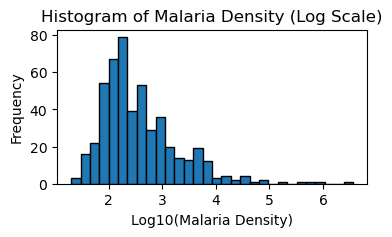

Proportion of non-zero densities: 0.09


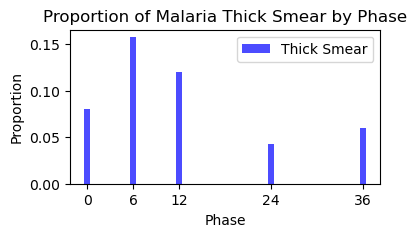

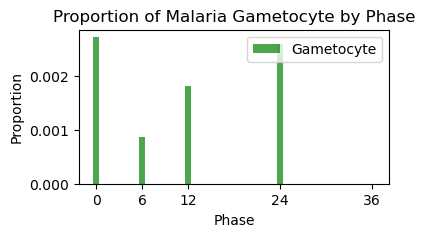

In [108]:
# Plot histogram of malaria_density
plt.figure(figsize=(4, 2))
plt.hist(np.log10(child_visit_df['malaria_density'][child_visit_df['malaria_density'] > 0]), bins=30, edgecolor='black')
plt.title('Histogram of Malaria Density (Log Scale)')
plt.xlabel('Log10(Malaria Density)')
plt.ylabel('Frequency')
plt.show()
print(f"Proportion of non-zero densities: {np.mean(child_visit_df['malaria_density'] > 0):.2f}")

# Calculate proportions for malaria_thicksmear and malaria_gameto by phase
malaria_summary = (
    child_visit_df.groupby('phase')[['malaria_thicksmear', 'malaria_gameto']]
    .mean()
    .reset_index()
)

# Plot bar chart for malaria_thicksmear proportion by phase
plt.figure(figsize=(4, 2))
plt.bar(malaria_summary['phase'], malaria_summary['malaria_thicksmear'], color='blue', alpha=0.7, label='Thick Smear')
plt.title('Proportion of Malaria Thick Smear by Phase')
plt.xlabel('Phase')
plt.ylabel('Proportion')
plt.xticks(malaria_summary['phase'])
plt.legend()
plt.show()

# Plot bar chart for malaria_gameto proportion by phase
plt.figure(figsize=(4, 2))
plt.bar(malaria_summary['phase'], malaria_summary['malaria_gameto'], color='green', alpha=0.7, label='Gametocyte')
plt.title('Proportion of Malaria Gametocyte by Phase')
plt.xlabel('Phase')
plt.ylabel('Proportion')
plt.xticks(malaria_summary['phase'])
plt.legend()
plt.show()

# Individual children

In [144]:
# Find the children with the greatest number of entries
child_entry_counts = seropositivity_wide.groupby('childid_public').size()
children_with_max_entries = child_entry_counts[child_entry_counts == 5]
children_with_max_entries_ids = children_with_max_entries.index
print("Number of children with the greatest number of entries:", len(children_with_max_entries_ids))

Number of children with the greatest number of entries: 34


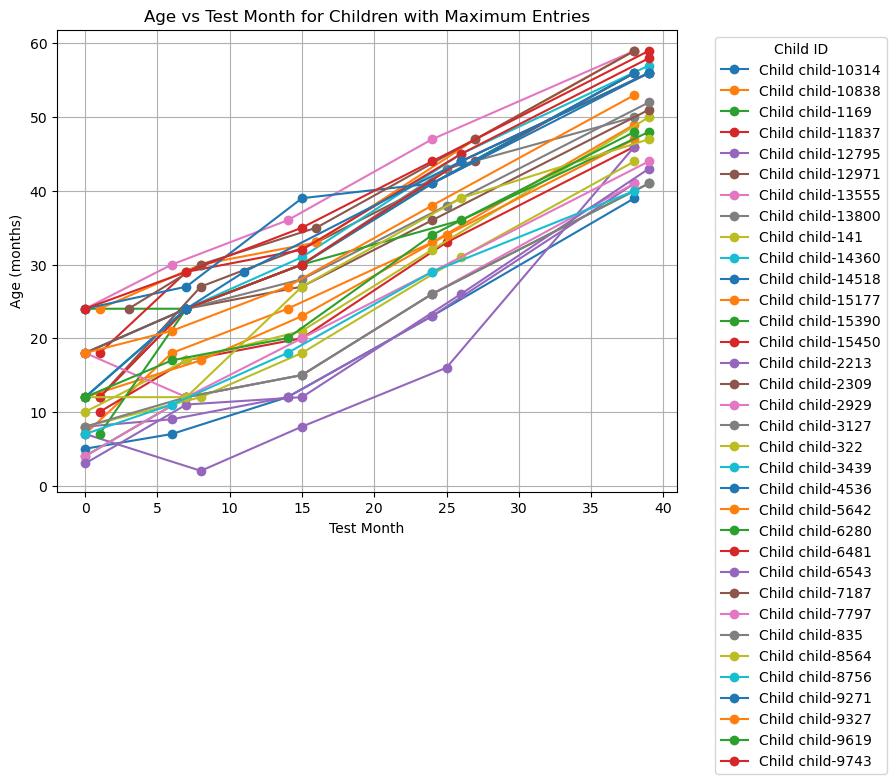

In [155]:
#### OPTIONS ####
agem_var = 'agem'  # Options: 'agem', 'agem_est'
#################

# use child_visit_df to plot age against test_month for each of the children with the greatest number of entries
child_visit_max_entries = (
    child_visit_df[child_visit_df['childid_public'].isin(children_with_max_entries_ids)]
    .sort_values(by=['childid_public', 'test_month'])
)
plt.figure(figsize=(8, 6))
for child_id in children_with_max_entries_ids:
    child_data = child_visit_max_entries[child_visit_max_entries['childid_public'] == child_id]
    plt.plot(child_data['test_month'], child_data[agem_var], marker='o', label=f'Child {child_id}')
plt.title('Age vs Test Month for Children with Maximum Entries')
plt.xlabel('Test Month')
plt.ylabel('Age (months)')
plt.legend(title='Child ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

Example child with maximum entries: child-1169
Ages (months) of tests: [41 24 24 30 56]


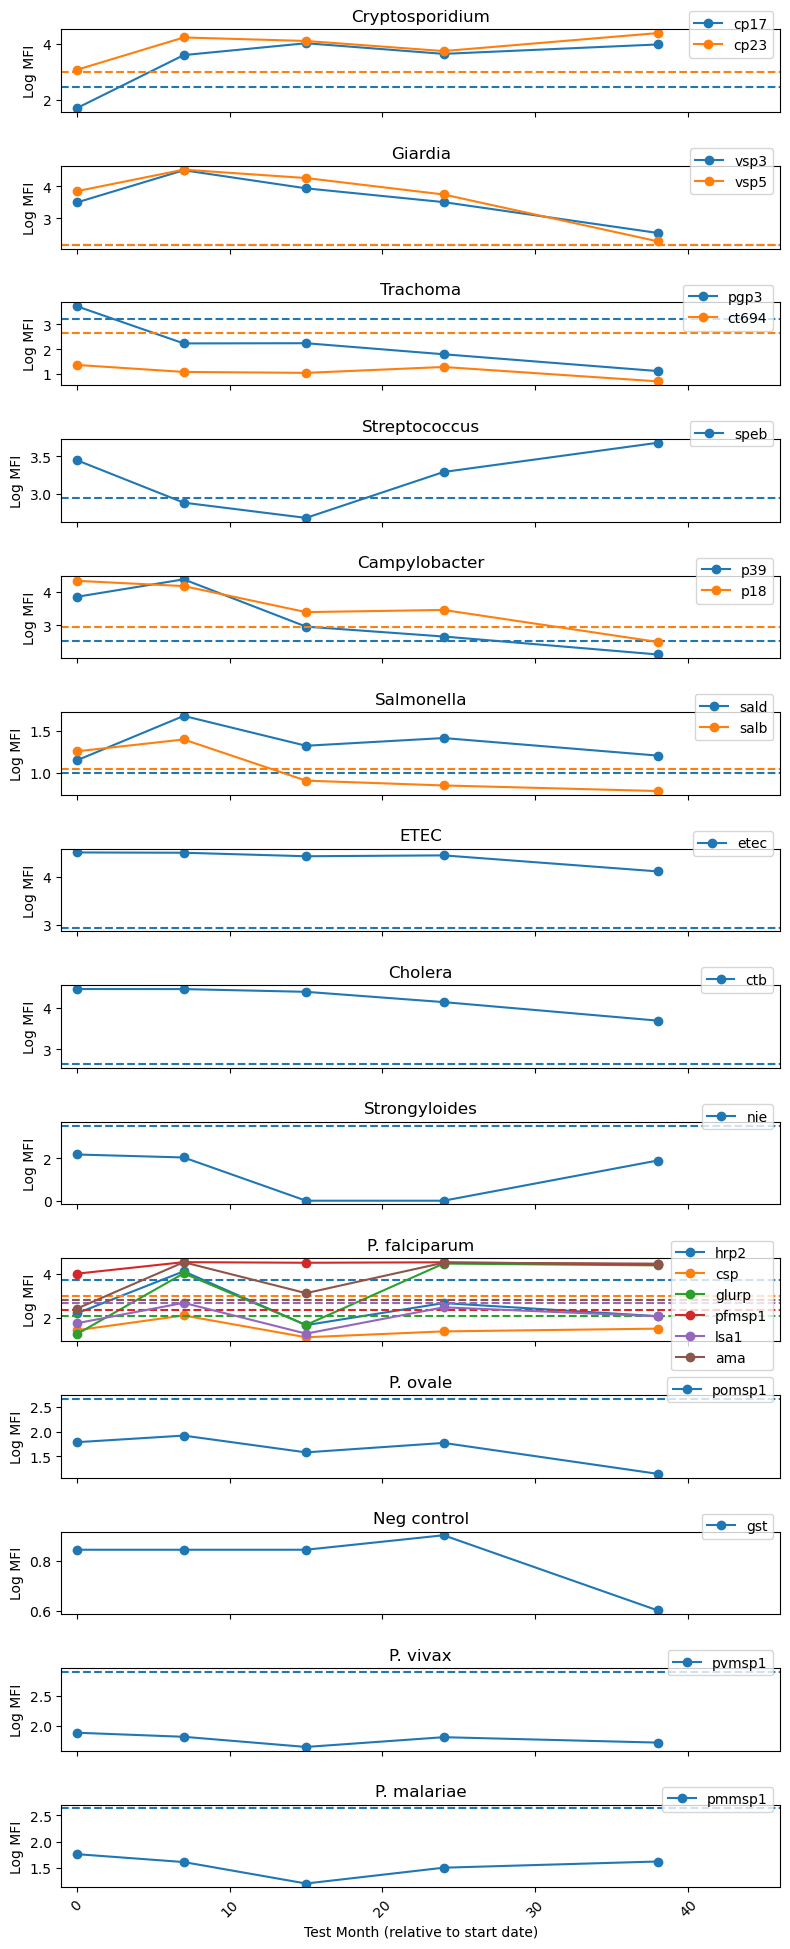

In [146]:
child_example = children_with_max_entries.index[2]
print(f'Example child with maximum entries: {child_example}')
print(f"Ages (months) of tests: {child_visit_df[child_visit_df['childid_public'] == child_example]['agem'].values}")
# Plot logmfi against testdate for each pathogen, with multiple antigens in each panel
child_sero_data = sero_df[sero_df['childid_public'] == child_example]

# Get unique pathogens
pathogens = child_sero_data['pathogen'].unique()

# Create subplots
fig, axes = plt.subplots(len(pathogens), 1, figsize=(8, 1.4 * len(pathogens)), sharex=True)  # Taller panels
for i, pathogen in enumerate(pathogens):
    pathogen_data = child_sero_data[child_sero_data['pathogen'] == pathogen]
    antigens = pathogen_data['antigen'].unique()
    for antigen in antigens:
        antigen_data = pathogen_data[pathogen_data['antigen'] == antigen].sort_values(by='test_month')
        logserocut_value = pathogen_antigen_df[pathogen_antigen_df['antigen'] == antigen]['logserocut'].values[0]
        if not antigen_data.empty:
            # Plot logmfi line
            line, = axes[i].plot(antigen_data['test_month'], antigen_data['logmfi'], marker='o', linestyle='-', label=antigen)
            # Plot serocut line with the same color as the logmfi line
            axes[i].axhline(logserocut_value, color=line.get_color(), linestyle='--')
    # Extend x-axis by 1 year
    min_month = child_sero_data['test_month'].min() - 1
    max_month = child_sero_data['test_month'].max() + 8
    axes[i].set_xlim([min_month, max_month])
    # Add labels and title
    axes[i].set_ylabel('Log MFI')
    axes[i].set_title(f'{pathogen}')
    # Shift legend up by 0.3
    axes[i].legend(loc='upper right', bbox_to_anchor=(1, 1.3))
# Set common x-axis label
axes[-1].set_xlabel('Test Month (relative to start date)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## log mfi over time

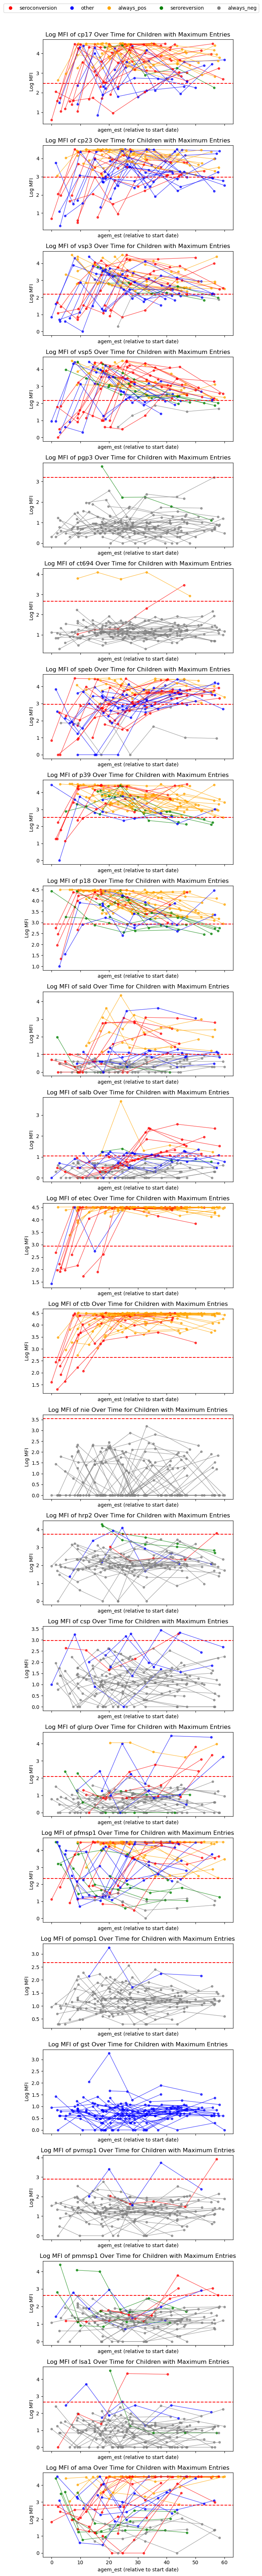

In [171]:
#### OPTIONS ####
time_axis = 'agem_est'  # Options: 'test_month', 'agem_est'
#################

unique_antigens = sero_df['antigen'].unique()
n_antigens = len(unique_antigens)

# Create subplots for each antigen
fig, axes = plt.subplots(n_antigens, 1, figsize=(6, 3 * n_antigens), sharex=True)

# Ensure axes is iterable even if there's only one antigen
if n_antigens == 1:
    axes = [axes]

# Initialize a dictionary to track patterns and their colors
color_map = {'always_neg': 'grey', 'always_pos': 'orange', 'seroconversion': 'red', 'seroreversion': 'green', 'other': 'blue'}
global_legend_items = {}

# Loop through each antigen and create a subplot
for i, antigen in enumerate(unique_antigens):
    ax = axes[i]
    child_sero_data = (
        sero_df[sero_df['childid_public'].isin(children_with_max_entries.index) & (sero_df['antigen'] == antigen)]
        .sort_values(by=['childid_public', 'test_month'])
        .assign(
            pattern=lambda df: df.groupby('childid_public')['seropos'].transform(
                lambda x: (
                    'always_neg' if (x == 0).all() else
                    'always_pos' if (x == 1).all() else
                    'seroconversion' if ((x.diff() == 1).sum() == 1 and (x.diff().fillna(0).isin([0, 1])).all()) else
                    'seroreversion' if ((x.diff() == -1).sum() == 1 and (x.diff().fillna(0).isin([0, -1])).all()) else
                    'other'
                )
            )
        )
    )

    for child in children_with_max_entries.index:
        child_data = child_sero_data[child_sero_data['childid_public'] == child]
        if not child_data.empty:
            pattern = child_data['pattern'].iloc[0]
            color = color_map[pattern]

            # Add the pattern and color to the global legend items
            if pattern not in global_legend_items:
                global_legend_items[pattern] = color

            ax.plot(
                child_data[time_axis],
                child_data['logmfi'],
                marker='o',
                linestyle='-',
                color=color,
                linewidth=1,
                markersize=4,
                alpha=0.7
            )

    # Add the serocut line to the plot
    ax.axhline(
        pathogen_antigen_df[pathogen_antigen_df['antigen'] == antigen]['logserocut'].values[0],
        color='red',
        linestyle='--',
        label='Serocut'
    )

    # Add title and labels
    ax.set_title(f'Log MFI of {antigen} Over Time for Children with Maximum Entries')
    ax.set_xlabel(f'{time_axis} (relative to start date)')
    ax.set_ylabel('Log MFI')

# Add a global legend to the figure
handles = [plt.Line2D([0], [0], color=color, marker='o', linestyle='', label=pattern) for pattern, color in global_legend_items.items()]
fig.legend(
    handles=handles,
    loc='upper center',
    bbox_to_anchor=(0.5, 1),  # Adjust position
    ncol=min(len(global_legend_items), 5)  # Limit the number of columns
)

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.99])  # Leave space for the global legend
plt.show()

# Serological analysis

In [59]:
# Filter out 'gst' from antigen columns
antigen_columns = pathogen_antigen_df['antigen'].tolist()
antigen_columns = [col for col in antigen_columns if col != 'gst']

# Create lagged columns for each antigen dynamically
seropositivity_wide_with_covariates = (
    seropositivity_wide
    .sort_values(by=['childid_public', 'test_month'])
    .assign(
        phase_lag=lambda df: df.groupby('childid_public')['phase'].shift(1),
        test_month_lag=lambda df: df.groupby('childid_public')['test_month'].shift(1),
        **{f"{col}_lag": lambda df, col=col: df.groupby('childid_public')[col].shift(1) for col in antigen_columns}
    )
    .groupby('childid_public')
    .tail(-1)
    .reset_index(drop=True)
    .merge(
        child_visit_df[['childid_public', 'test_month',
                           'arm', 'agem', 'clusterid_public', 'sex',
                           'malaria_thicksmear', 'malaria_gameto', 'malaria_density']],
        on=['childid_public', 'test_month'],
        how='left'
    )
)

In [ ]:
#### OPTIONS ####
antigen = 'speb' # Choose an antigen to analyse e.g. 'ctb', 'pmmsp1'
#################


# Create antigen_survivor_df
antigen_survivor_df = (
    seropositivity_wide_with_covariates
    .loc[seropositivity_wide_with_covariates[f"{antigen}_lag"] == 0]
    .assign(
        seroconversion=lambda df: (df[antigen] == 1) & (df[f"{antigen}_lag"] == 0),
        left_trunc=lambda df:df['test_month_lag'],
        int_lower=lambda df: np.where(df['seroconversion'], df['test_month_lag'], df['test_month']),
        int_upper=lambda df: np.where(df['seroconversion'], df['test_month'], np.inf)
    )
)


cph = CoxPHFitter(baseline_estimation_method='piecewise', breakpoints=[12,24])
# Fit the Cox Proportional Hazards model
cph.fit_interval_censoring(
    antigen_survivor_df,
    lower_bound_col = 'int_lower',  # Lower bounds of interval-censored times
    upper_bound_col = 'int_upper',  # Upper bounds of interval-censored times
    entry_col = 'left_trunc',  # Left truncation times
    formula = "1"  # Formula for the model, using lagged values
)

# # Fit the Kaplan-Meier model for interval-censored data with left truncation
# kmf = KaplanMeierFitter()
# kmf.fit_interval_censoring(
#     lower_bound = antigen_survivor_df['int_lower'],  # Lower bounds of interval-censored times
#     upper_bound = antigen_survivor_df['int_upper']  # Upper bounds of interval
#     #entry =  antigen_survivor_df['left_trunc'] # Left truncation times ##NotImplementedError
# )

<lifelines.CoxPHFitter: fitted with 926 total observations, 926 interval-censored observations>

<lifelines.CoxPHFitter: fitted with 926 total observations, 926 interval-censored observations>
          lower bound col = 'int_lower'
          upper bound col = 'int_upper'
                event col = 'E_lifelines_added'
                entry col = 'left_trunc'
       location of breaks = [12, 24]
      baseline estimation = piecewise
   number of observations = 926
number of events observed = 0
           log-likelihood = -584.80
         time fit was run = 2025-07-21 13:45:49 UTC

---
                        coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param        covariate                                                                                                  
beta_        Intercept -3.36      0.03      0.13           -3.60           -3.11                0.03                0.04
log_lambda2_ Intercept -0.02      0.98      0.20           -0.40            0.36                0.67                1.44
log_lambda3_ Intercept -0.15      0.86      0.17           -0.48            0.18                0.62                1.20

                        cmp to      z      p  -log2(p)
param        covariate                                
beta_        Intercept    0.00 -26.84 <0.005    524.73
log_lambda2_ Intercept    0.00  -0.10   0.92      0.12
log_lambda3_ Intercept    0.00  -0.87   0.38      1.38
---
AIC = 1175.60
log-likelihood ratio test = 0.00 on 0 df
-log2(p) of ll-ratio test = nan

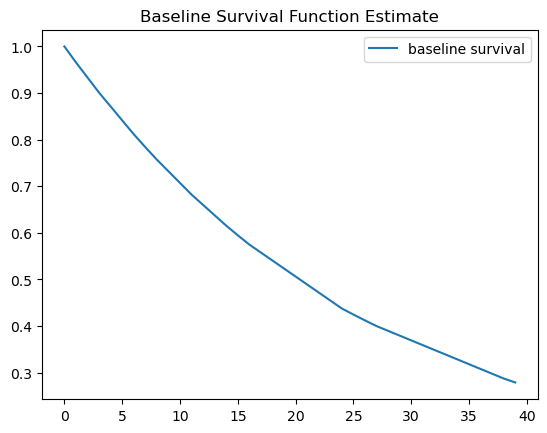

In [78]:
#plot the baseline survivor function of cph
ax = cph.baseline_survival_.plot(title="Baseline Survival Function Estimate")
#display summary statistics
cph.print_summary()

In [73]:
#### OPTIONS ####
antigen = 'lsa1' # Choose an antigen to analyse e.g. 'ctb', 'lsa1'
#################

# Create antigen_survivor_df
antigen_survivor_df_by_phase = (
    seropositivity_wide_with_lags
    .loc[seropositivity_wide_with_lags[f"{antigen}_lag"] == 0]
    .assign(
        seroconversion=lambda df: (df[antigen] == 1) & (df[f"{antigen}_lag"] == 0),
        left_trunc=lambda df: df['phase_lag'],
        duration=lambda df: df['phase'],
        event=lambda df: df[antigen]
    )
)

cph = CoxPHFitter()
# Fit the Cox Proportional Hazards model by phase
cph.fit(
    antigen_survivor_df_by_phase,
    duration_col='duration',
    event_col='event',
    entry_col='left_trunc',  # Left truncation times
    formula="-1"  # No covariates, just the baseline hazard
)

<lifelines.CoxPHFitter: fitted with 1717 total observations, 1657 right-censored observations>

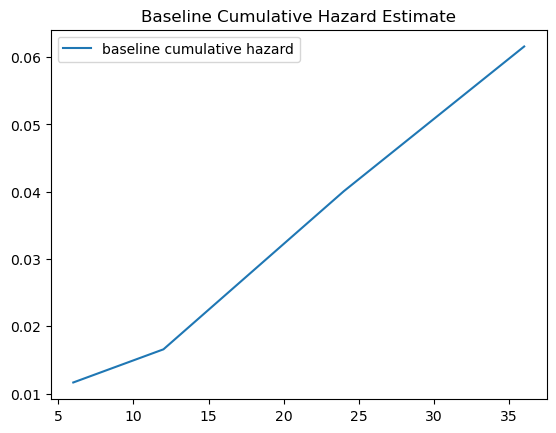

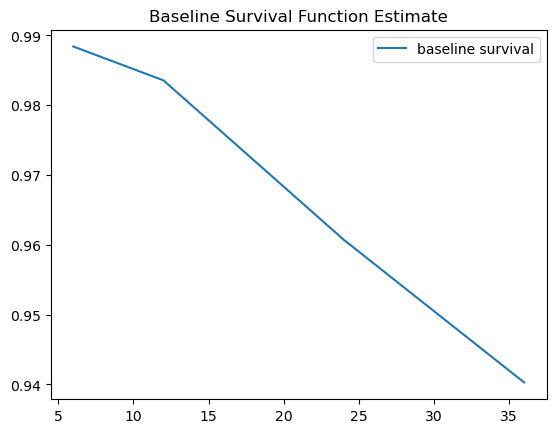

In [74]:
# Plot baseline cumulative hazard with ground truth cumulative hazard
ax = cph.baseline_cumulative_hazard_.plot(title="Baseline Cumulative Hazard Estimate")
ax.legend()

# Plot baseline survival with ground truth survivor
ax2 = cph.baseline_survival_.plot(title="Baseline Survival Function Estimate")
ax2.legend()